In [68]:
import pandas as pd

FILE = "INFLUD23-17-06-2024.csv"

INFLUD = pd.read_csv(FILE, sep=';')
POPULATION = pd.read_csv("StatePopulation.csv")
POPULATION.drop(columns=["STATE"], inplace=True)

/tmp/ipykernel_127771/2690819796.py:5: DtypeWarning: Columns (15,18,20,23,53,61,62,63,72,74,79,91,93,109,130,143,175,178) have mixed types. Specify dtype option on import or set low_memory=False.
  INFLUD = pd.read_csv(FILE, sep=';')


In [69]:
import pickle
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer, LabelEncoder

df = INFLUD.copy() 

# Filtra apenas os casos confirmados
df = df[df["CLASSI_FIN"].notna()]

# Agrupa por estado e data de notificação e conta o número de casos
df = df.groupby(["SG_UF_NOT", "DT_NOTIFIC"]).size().reset_index(name="CNT")

# Converte a data de notificação para o dia do ano
df["DOF_NOTIFIC"] = pd.to_datetime(df["DT_NOTIFIC"], format="%d/%m/%Y").dt.dayofyear
df.drop(columns="DT_NOTIFIC", inplace=True)


# Adiciona a população de cada estado
df = df.merge(POPULATION, left_on="SG_UF_NOT", right_on="UF")
df.drop(columns=["SG_UF_NOT"], inplace=True)

# Converte UF para numeral
uf_encoder = LabelEncoder()
df["UF"] = uf_encoder.fit_transform(df["UF"])
with open("uf.pickle", 'wb') as file:
    pickle.dump(uf_encoder, file, pickle.HIGHEST_PROTOCOL)

# risk_scaler = QuantileTransformer()
risk_scaler = MinMaxScaler()
df["RISK"] = df["CNT"] / df["POPULATION"]
df["RISK"] = risk_scaler.fit_transform(df[["RISK"]])

df.drop(columns=["CNT", "POPULATION"], inplace=True)

df

,DOF_NOTIFIC,UF,RISK
0,1,0,0.043576
1,32,0,0.109586
2,60,0,0.043576
3,91,0,0.109586
4,121,0,0.131589
...,...,...,...
9890,31,26,0.049226
9891,90,26,0.036812
9892,151,26,0.111298
9893,212,26,0.049226


In [70]:
import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

X = df[["DOF_NOTIFIC", "UF"]]
Y = df["RISK"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


# Modelo de Regressão Linear
linear_regression = LinearRegression()
linear_regression.fit(X_train, Y_train)

Y_pred = linear_regression.predict(X_test)

joblib.dump(linear_regression, "linear_regression.pkl")
linear_mae = mean_absolute_error(Y_test, Y_pred)
print("Mean Absolute Error (Linear Regression):", linear_mae)

# Modelo de Árvore de Decisão
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, Y_train)
joblib.dump(tree_model, 'decision-tree.pkl')

tree_Y_pred = tree_model.predict(X_test)

tree_mae = mean_absolute_error(Y_test, tree_Y_pred)
print("Mean Absolute Error (Decision Tree):", tree_mae)


# Modelo de Random Forest
forest_model = RandomForestRegressor(random_state=42)
forest_model.fit(X_train, Y_train)
joblib.dump(forest_model, 'random-forest.pkl')

forest_Y_pred = forest_model.predict(X_test)

forest_mae = mean_absolute_error(Y_test, forest_Y_pred)
print("Mean Absolute Error (Random Forest):", forest_mae)

Mean Absolute Error (Linear Regression): 0.05165227219032609
Mean Absolute Error (Decision Tree): 0.03759681895258062
Mean Absolute Error (Random Forest): 0.031971093313456704


In [71]:
date = pd.to_datetime("16/06/2024", format="%d/%m/%Y").dayofyear
uf = uf_encoder.transform(["SP"])[0]

y = linear_regression.predict([[date, uf]])
y

/home/kauan/Documents/Uni/machine-learning-abp/.venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([0.05457491])

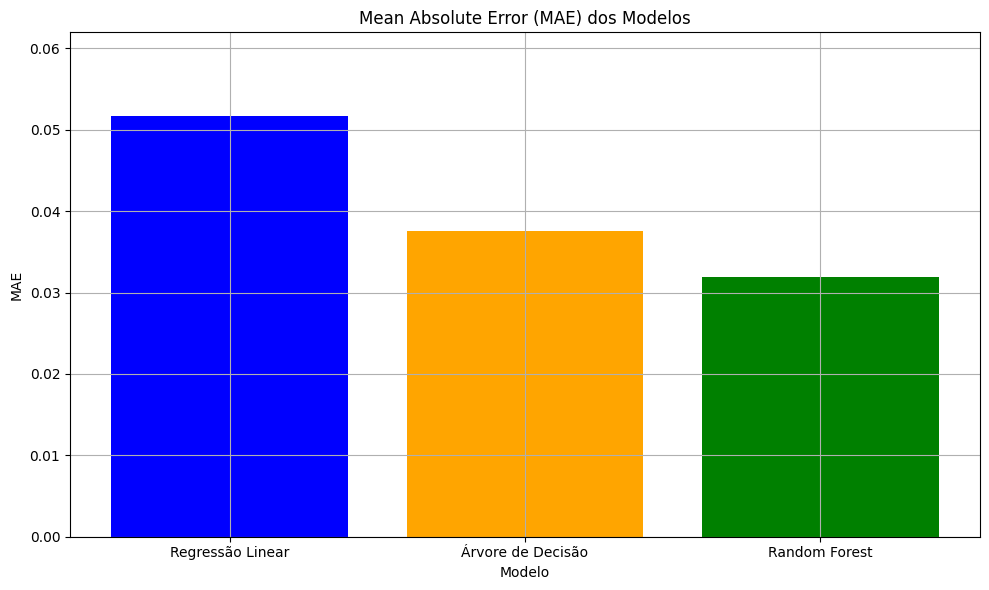

In [72]:
import matplotlib.pyplot as plt
# Converter DOF_NOTIFIC de dia do ano para data
df['DATA'] = pd.to_datetime(df['DOF_NOTIFIC'], format='%j').dt.date

# Criar gráfico de barras do MAE dos modelos
plt.figure(figsize=(10, 6))

models = ['Regressão Linear', 'Árvore de Decisão', 'Random Forest']
mae_values = [linear_mae, tree_mae, forest_mae]

plt.bar(models, mae_values, color=['blue', 'orange', 'green'])
plt.title('Mean Absolute Error (MAE) dos Modelos')
plt.xlabel('Modelo')
plt.ylabel('MAE')
plt.ylim(0, max(mae_values) * 1.2)  # Ajustar limite superior do eixo y para melhor visualização
plt.grid(True)

plt.tight_layout()
plt.show()

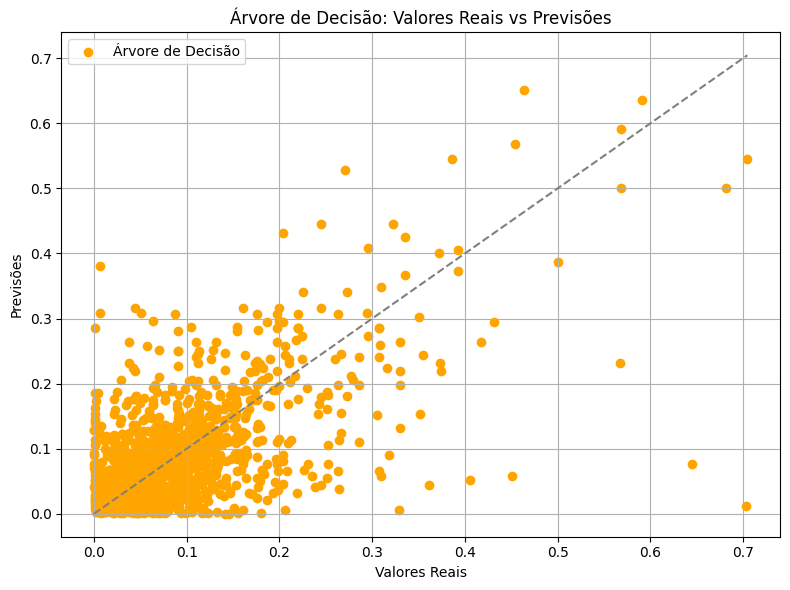

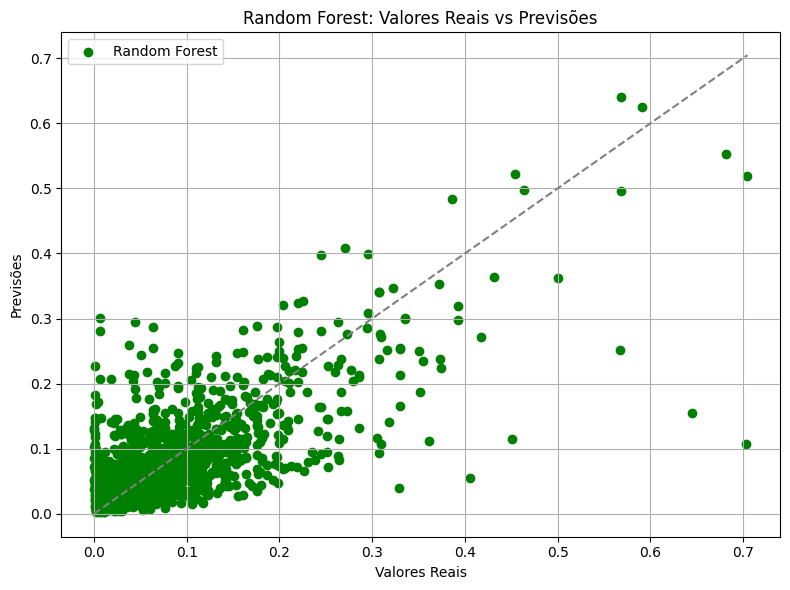

In [73]:
# Plotar valores reais versus previsões da Árvore de Decisão
plt.figure(figsize=(8, 6))
plt.scatter(Y_test, tree_Y_pred, color='orange', label='Árvore de Decisão')
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], '--', color='gray')  # linha de referência
plt.title('Árvore de Decisão: Valores Reais vs Previsões')
plt.xlabel('Valores Reais')
plt.ylabel('Previsões')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotar valores reais versus previsões do Random Forest
plt.figure(figsize=(8, 6))
plt.scatter(Y_test, forest_Y_pred, color='green', label='Random Forest')
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], '--', color='gray')  # linha de referência
plt.title('Random Forest: Valores Reais vs Previsões')
plt.xlabel('Valores Reais')
plt.ylabel('Previsões')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

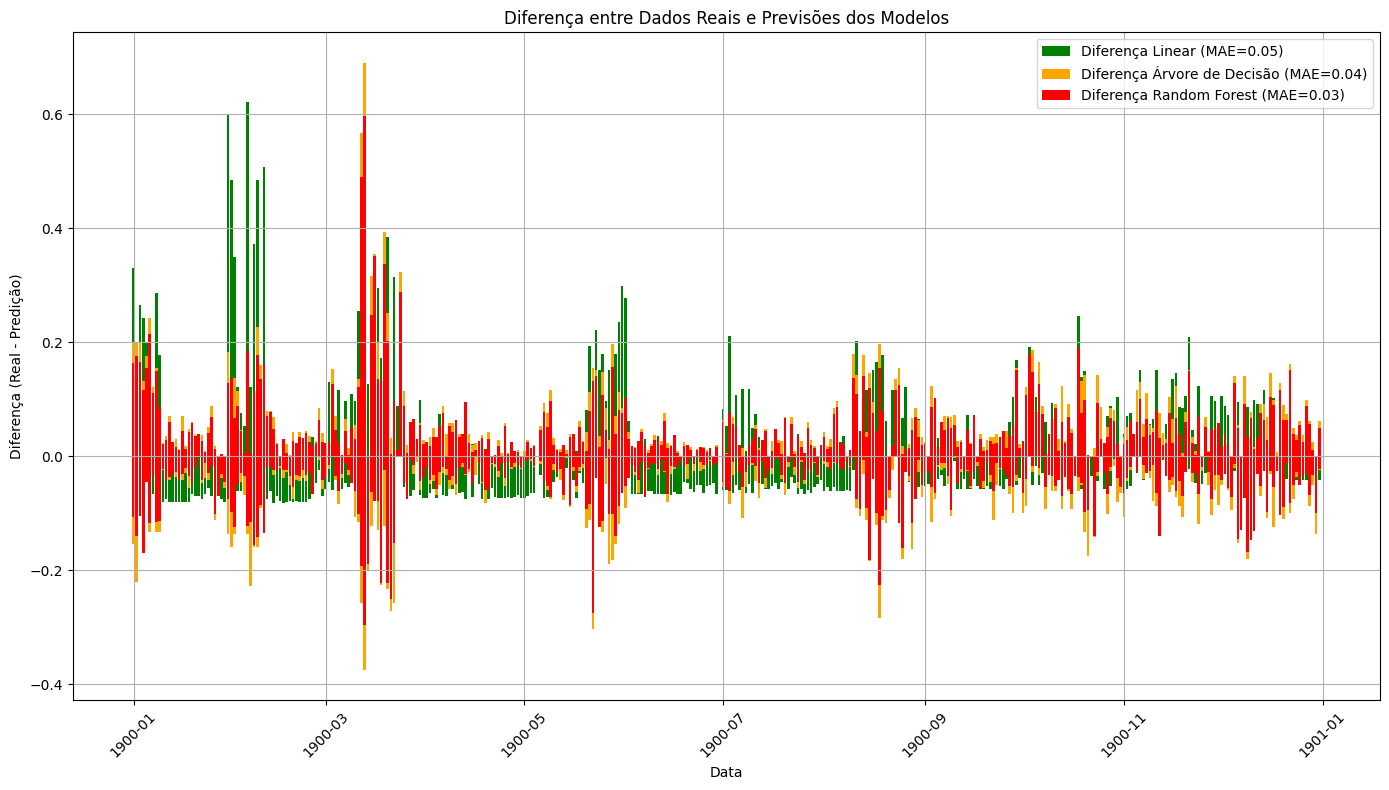

In [74]:
# Converter DOF_NOTIFIC de dia do ano para data
df['DATA'] = pd.to_datetime(df['DOF_NOTIFIC'], format='%j').dt.date

# Ordenar DataFrame pela data para plotagem correta
df.sort_values(by='DATA', inplace=True)

# Calcular a diferença entre dados reais e previsões
diff_linear = Y_test - Y_pred
diff_tree = Y_test - tree_Y_pred
diff_forest = Y_test - forest_Y_pred

# Criar gráfico de barras com a diferença entre dados reais e previsões dos modelos
plt.figure(figsize=(14, 8))

# Plotar diferença da Regressão Linear
plt.bar(df['DATA'].iloc[X_test.index], diff_linear, label=f'Diferença Linear (MAE={linear_mae:.2f})', color='green')

# Plotar diferença da Árvore de Decisão
plt.bar(df['DATA'].iloc[X_test.index], diff_tree, label=f'Diferença Árvore de Decisão (MAE={tree_mae:.2f})', color='orange')

# Plotar diferença do Random Forest
plt.bar(df['DATA'].iloc[X_test.index], diff_forest, label=f'Diferença Random Forest (MAE={forest_mae:.2f})', color='red')

plt.title('Diferença entre Dados Reais e Previsões dos Modelos')
plt.xlabel('Data')
plt.ylabel('Diferença (Real - Predição)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()